In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from qiskit_aer import AerSimulator
from qiskit.circuit import QuantumCircuit
from qiskit.quantum_info import Pauli, Statevector, Operator, random_hermitian, SparsePauliOp
from qiskit_ibm_runtime.fake_provider import FakeManilaV2 # Retired quantum processor
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime import QiskitRuntimeService
from scipy.interpolate import UnivariateSpline
from scipy.stats import chi2

import sys
import os

In [2]:
backend_name = "aer" #manila, aer, ibm, ionq
trotter_order= "first" #first, second

<!-- simulator_backend = provider.get_backend("simulator")
# Run the circuit on IonQ's platform:
job = simulator_backend.run(qc, shots=10000)

# Print the counts
print(job.get_counts()) -->

In [3]:
import qiskit 
qiskit.version.get_version_info() 

'1.1.1'

In [4]:
import qiskit_ibm_runtime 
qiskit_ibm_runtime .version.get_version_info() 

'0.24.1'

In [5]:

#ionq backend start
from qiskit import transpile

# Load the API key from the environment variable
api_key = os.getenv('IONQ_API_KEY')
from qiskit_ionq import IonQProvider
# provider = IonQProvider()
api_key = "zneojFDA2Je63szoO1GYFi7EwQO9FEnQ"
provider = IonQProvider(api_key)
print(provider.backends())

[<IonQSimulatorBackend('ionq_simulator')>, <IonQQPUBackend('ionq_qpu')>]


In [6]:

# Determine the correct path for the 'src' directory
if '__file__' in globals():
    # Running as a script
    src_dir = os.path.abspath(os.path.join(os.path.dirname(__file__), '..', 'src'))
else:
    # Running in an interactive environment like Jupyter Notebook
    src_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))

sys.path.append(src_dir)


In [7]:
from hamiltonian import construct_hamiltonian
from momentum import momentum
from evolve import evolve_and_measure_circuit
from constants import hbar, c , eV, MeV, GeV, G_F, kB

In [28]:
def initialize_parameters():
    N_sites_eachflavor= 1 # total sites/particles/qubits that are evenly spaced "for each (electron) flavor" 
    N_sites = 2* (N_sites_eachflavor) # total particles/sites/qubits for all neutrino and anti neutrino electron flavored 
    m1 = -0.008596511*eV #ergs #1st mass eigenstate of neutrino in Richers(2021)
    m2 = 0*eV   #ergs #2nd mass eigenstate of neutrino in Richers(2021)
    delta_m_squared = (m2**2 - m1**2) # mass square difference # (erg^2)
    
    shots = 1024
    trotter_steps= 100 # Number of Trotter steps per time step
    if backend_name == 'manila':
        backend = FakeManilaV2()
    elif backend_name == 'aer':
        backend = AerSimulator(method='automatic')
    elif backend_name == 'ibm':
        # Define the service to access IBM Quantum systems.
        service = QiskitRuntimeService()
        backend = service.least_busy(operational=True, simulator=False)
    elif backend_name == 'ionq':
        backend = provider.get_backend("simulator")
    alpha = 5e-10 # significance level i.e. percentage/probability of rejecting the null hypothesis when it is actually true (a type  # it's the probability risk we're willing to take of making a false positive conclusion.
    df = 1 # degrees of freedom for chisquare test
    τ = 1.666e-4  # Time step
    ttotal = 1.666e-2 # total time of evolution # sec #variable
    times = np.arange(0, τ + ttotal, τ)  # Define time steps
    L = 1e7 # cm # domain size # (aka big box length)
    n_νₑ =  2.92e24 # cm^-3 # number density of electron flavor neutrino
    n_νₑ̄ =  n_νₑ # cm^-3 # number density of electron flavor antineutrino
    Eνₑ =  50*MeV # energy of all neutrinos (P.S the its negative is energy of all antineutrinos)
    Eνₑ̄ = -1 * Eνₑ # specific to my case only. Since all neutrinos have same energy, except in my case anti neutrinos are moving in opposite direction to give it a negative sign
    Δx = L # length of the box of interacting neutrinos at a site in cm
    Δp = L # width of shape function # not being used in this test but defined to keep the evolve function arguments consistent.
    t1 = 0.0084003052 #choose initial time for growth rate calculation #variable, not being used in this test
    t2 = 0.011700318 #choose final time for growth rate calculation #variable, not being used in this test
    theta_nu = 1.74532925E-8  #1e-6 degrees # mixing_angle # = 1.74532925E-8 radians 
    periodic = True

    V = L**3# volume of the big box containing all sites/particles
    # Create an array of dimension N and fill it half with values of sites containing all electron neutrinos 
    # # and other half with sites containing electron anti-neutrino. 
    N_νₑ  = n_νₑ * V 
    N_1 = np.full(N_sites // 2, N_νₑ)
    N_νₑ̄  = n_νₑ̄ * V 
    N_2 = np.full(N_sites // 2, N_νₑ̄)

    # Concatenate the arrays to get the total number of neutrinos
    N = np.concatenate((N_1, N_2))
    
    # Create a B vector which would be same for all N particles
    B = np.array([-np.sin(2 * theta_nu), 0, np.cos(2 * theta_nu)])
    B = B / np.linalg.norm(B)



    # Function to generate x_array such that the first particle is at position L/(2*N_sites)
    # while subsequent particles are at a position incremental by L/N_sites (grid style)
    def generate_x_array(N_sites, L):
        return [(i - 0.5) * L / N_sites for i in range(1, N_sites + 1)]
    
    # Generate position arrays
    x = generate_x_array(N_sites, L)
    y = generate_x_array(N_sites, L)
    z = generate_x_array(N_sites, L)
    
    # Function to generate a momentum array in px direction
    # that depicts the energy of neutrinos and anti-neutrinos in opposing beams
    def generate_px_array(N_sites):
        half_N_sites = N_sites // 2
        return np.concatenate([np.full(half_N_sites, Eνₑ), np.full(half_N_sites, Eνₑ̄)])

    def generate_py_array(N_sites):
        half_N_sites = N_sites // 2
        return np.concatenate([np.zeros(half_N_sites), np.zeros(half_N_sites)])

    def generate_pz_array(N_sites):
        half_N_sites = N_sites // 2
        return np.concatenate([np.zeros(half_N_sites), np.zeros(half_N_sites)])

    # Generate momentum arrays
    px = generate_px_array(N_sites)
    py = generate_py_array(N_sites)
    pz = generate_pz_array(N_sites)

    # p matrix with numbers generated from the p_array for all components (x, y, z)
    p = np.column_stack((px, py, pz))

    # Create an array with the first half as 1 and the rest as -1
    energy_sign = np.array([-1 if i < N_sites // 2 else 1 for i in range(N_sites)])
    p_mod, p_hat = momentum(p, N_sites)
    # Calculate omega for each site
    omega = [delta_m_squared / (2 * p_mod[i]) * energy_sign[i] for i in range(N_sites)]
    print(omega)

    #modify this shape_name dict thing
    shape_name = 1  # variable.  #Select a shape function based on the shape_name variable form the list defined in dictionary in shape_func file

    return N_sites, theta_nu, omega, B, N, x, p, energy_sign, Δx, Δp, L, delta_m_squared, shape_name , shots, trotter_steps, backend, alpha,df, τ, times,ttotal, periodic

In [29]:
def evolve_and_simulate(times, omega, N_sites,x, p, L, pauli_terms, theta_nu, backend, shots, τ, alpha,df, ttotal, periodic, trotter_steps, trotter_order):
    datadir = os.path.join(os.getcwd(), "..", "misc", "datafiles", "FFI", f"par_{N_sites}", f"tt_{ttotal}", f"shots_{shots}")
    if not os.path.isdir(datadir):
        os.makedirs(datadir)
        
    # Simulation and expected value calculation
    sigma_x_values = []
    sigma_y_values = []
    sigma_z_values = []
    ρₑₑ_array = []
    ρ_μμ_array = []
    ρₑμ_array = []
    survival_probabilities = []
    # Initialize a list to store sigma_x values
    sigma_x_list = []
    sigma_xbar_i = []
    # Create empty arrays to store the respective values
    x_values = []
    px_values = []
    # Extract output of p_hat and p_mod for the p vector defined above for all sites
    p_mod, p_hat = momentum(p, N_sites)
    p_hat_x = [sub_array[0] for sub_array in p_hat]
    
    for t in times:
        # Evolve and measure circuit for sigma_z
        qc_z = evolve_and_measure_circuit(t, pauli_terms,  N_sites, theta_nu,trotter_steps,trotter_order, measure='Z')

        if backend_name == 'ionq':
            qc_z = transpile(qc_z, backend=backend)
            job_z = backend.run(qc_z, shots=shots)
            counts_z = job_z.get_counts()
            isa_circuit_z = qc_z # added for consistency with function return for all backends (not an actual ISA circuit, ionq doesnt have those)
        else :
            pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
            isa_circuit_z = pm.run(qc_z)
        
            # Get counts from the result
            sampler = Sampler(mode=backend)
            job_z = sampler.run([isa_circuit_z],shots=shots)
            result_z = job_z.result()
            pub_result_z = result_z[0]
            counts_z = pub_result_z.data.c.get_counts()


        x_values.append(x.copy())  # Record x values at each time step
        px = p[:, 0]  # Extracting the first column (which corresponds to px values)
        px_values.append(px.copy())  # Record px values at each time step

        for i in range(N_sites):
            x[i] += p_hat_x[i] * c * τ
            if periodic:
                # Wrap around position from 0 to domain size L
                x[i] = x[i] % L

                # Checking if the updated x[i] satisfies the boundary conditions
                assert 0 <= x[i] <= L
                
                
        # Calculate expectation value of sigma_z for the first qubit
        sigma_z = 0
        for outcome, count in counts_z.items():
            if outcome[0] == '0':
                sigma_z += count / shots
            else:
                sigma_z -= count / shots

        # Evolve and measure circuit for sigma_x
        qc_x = evolve_and_measure_circuit(t, pauli_terms, N_sites,theta_nu,trotter_steps, trotter_order, measure='X')
        if backend_name == 'ionq':
            qc_x = transpile(qc_x, backend=backend)
            job_x = backend.run(qc_x, shots=shots)
            counts_x = job_x.get_counts()
            isa_circuit_x = qc_x # added for consistency with function return for all backends (not an actual ISA circuit, ionq doesnt have those)
        else :
            pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
            isa_circuit_x = pm.run(qc_x)

            # Get counts from the result
            sampler = Sampler(mode=backend)
            job_x = sampler.run([isa_circuit_x],shots=int(shots))
            result_x = job_x.result()
            pub_result_x = result_x[0]
            counts_x = pub_result_x.data.c.get_counts()

        # Calculate expectation value of sigma_x for the first qubit
        sigma_x = 0
        for outcome, count in counts_x.items():
            if outcome[0] == '0':
                sigma_x += count / shots
            else:
                sigma_x -= count / shots
        print("sigma_x_mean_should_be= ",sigma_x)
        
        # sigma_x = 0
        sigma_x = np.zeros(shots)  # Initialize an array to store sigma_x values for all shots

        # Fill the sigma_x array with values for each shot
        index = 0
        for outcome, count in counts_x.items():
            value = 1 if outcome == '0' else -1
            for _ in range(count):
                if index < shots:
                    sigma_x[index] = value
                    # print(f"Shot {index + 1}: sigma_x = {sigma_x[index]}")  # Print the value for each shot
                    index += 1

        # Calculate the mean of sigma_x for this time step
        mean_sigma_x = np.mean(sigma_x)
        print(f"mean_sigma_x is: {mean_sigma_x}")
            
        # Calculate the standard deviation using numpy's std function
        std_sigma_x_unadjusted = np.std(sigma_x, ddof=df)  # ddof=0 for population std, ddof=1 for sample std

        # Adjust the standard deviation to match the formula in the image
        std_sigma_x = std_sigma_x_unadjusted * np.sqrt(1 / (shots ))

        print(f"Standard Deviation of sigma_x: {std_sigma_x}\n")
        
        # # Calculate the sum of squared deviations from the mean
        # sum_squared_deviations = np.sum((sigma_x - mean_sigma_x) ** 2)

        # # Apply the custom formula for standard deviation
        # std_sigma_x = np.sqrt(sum_squared_deviations / (shots * (shots - 1)))

        # print(f"Standard Deviation using custom formula: {std_sigma_x}")

        sigma_x = mean_sigma_x #reassigned the <sigma_x> over all shots for each t in time 
        
        # Evolve and measure circuit for sigma_y
        qc_y = evolve_and_measure_circuit(t, pauli_terms, N_sites,theta_nu,trotter_steps, trotter_order,  measure='Y')

        if backend_name == 'ionq':
            qc_y = transpile(qc_y, backend=backend)
            job_y = backend.run(qc_y, shots=shots)
            counts_y = job_y.get_counts()
            isa_circuit_y = qc_y # added for consistency with function return for all backends (not an actual ISA circuit, ionq doesnt have those)
        else :
            pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
            isa_circuit_y = pm.run(qc_y)
            
            # Get counts from the result
            sampler = Sampler(mode=backend)
            job_y = sampler.run([isa_circuit_y],shots=int(shots))
            result_y = job_y.result()
            pub_result_y = result_y[0]
            counts_y = pub_result_y.data.c.get_counts()

        # Calculate expectation value of sigma_y for the first qubit
        sigma_y = 0
        for outcome, count in counts_y.items():
            if outcome[0] == '0':
                sigma_y += count / shots
            else:
                sigma_y -= count / shots

        # Calculate survival probability
        survival_probability = (1 - sigma_z) / 2
        # print(f"t: {t}, survival_probability: {survival_probability}")
        
        # Append values to the respective lists
        sigma_x_values.append(sigma_x)
        sigma_y_values.append(sigma_y)
        sigma_z_values.append(sigma_z)
        survival_probabilities.append(survival_probability)
        # Store the std_sigma_x value in sigma_xbar_i array
        sigma_xbar_i.append(std_sigma_x)
        
        
        # Recall that in our code sigma_z = 2 * Sz to make sure these expressions are consistent with "Sz in ITensors"
        ρₑₑ = ((sigma_z) + 1) / 2
        ρₑₑ_array.append(abs(ρₑₑ))
        ρ_μμ = ((-1*sigma_z) + 1) / 2
        ρ_μμ_array.append(abs(ρ_μμ))
        ρₑμ = np.sqrt((sigma_x/2)**2 + (sigma_y/2)**2)  
        ρₑμ_array.append(ρₑμ)

    # Create a spline of the survival probabilities
    spline = UnivariateSpline(times, survival_probabilities, s=0.02)
    survival_probabilities = spline(times) # smoothed survival_probabilities array
    
    
    spline = UnivariateSpline(times, ρₑₑ_array, s=0.02)
    ρₑₑ_array = spline(times) # smoothed ρₑₑ_array array
    
    spline = UnivariateSpline(times, ρ_μμ_array, s=0.02)
    ρ_μμ_array= spline(times) # smoothed ρ_μμ_array
    
    # spline = UnivariateSpline(times, ρₑμ_array, s=0.02)
    # ρₑμ_array = spline(times) # smoothed ρₑμ_array 
    
    
    fname1 = os.path.join(datadir, "t_<s_z>_<s_y>_<s_x>.dat")
    np.savetxt(fname1, np.column_stack((times, sigma_z_values, sigma_y_values, sigma_x_values)))
    fname2 = os.path.join(datadir, "t_probsurv.dat")
    np.savetxt(fname2, np.column_stack((times, survival_probabilities)))
    fname3 = os.path.join(datadir, "t_xsiteval.dat")
    np.savetxt(fname3, np.column_stack((times, x_values)))
    fname4 = os.path.join(datadir, "t_pxvalsite.dat")
    np.savetxt(fname4, np.column_stack((times, px_values)))
    fname5 = os.path.join(datadir, "t_ρₑₑ.dat")
    np.savetxt(fname5, np.column_stack((times, ρₑₑ_array)))
    fname6 = os.path.join(datadir, "t_ρ_μμ.dat")
    np.savetxt(fname6, np.column_stack((times, ρ_μμ_array)))
    fname7 = os.path.join(datadir, "t_ρₑμ.dat")
    np.savetxt(fname7, np.column_stack((times, ρₑμ_array)))
    fname8 = os.path.join(datadir, "t_sigma_xbar_i.dat")
    np.savetxt(fname8, np.column_stack((times, sigma_xbar_i)))

    return sigma_x_values, sigma_y_values, sigma_z_values, survival_probabilities, x_values, pₓ_values, ρₑₑ_array, ρ_μμ_array, ρₑμ_array, isa_circuit_x, sigma_xbar_i


In [30]:
def chi_square_test(par, tt, shots):
    # File paths
    file_path1 = f"../misc/datafiles/FFI/par_{par}/tt_{tt}/shots_{shots}/t_<s_z>_<s_y>_<s_x>.dat"
    file_path2 = f"../misc/datafiles/FFI/par_{par}/tt_{tt}/t_<Sz>_<Sy>_<Sx>_CC.dat"
    file_path3 = f"../misc/datafiles/FFI/par_{par}/tt_{tt}/shots_{shots}/t_sigma_xbar_i.dat"

    # Read and load the data from the files
    sx_data_QC = np.loadtxt(file_path1)  # observed data (sigma_x_QC)
    Sx_data_CC = np.loadtxt(file_path2)  # expected data (sigma_x_CC)
    sigma_i_data_QC = np.loadtxt(file_path3)  # standard deviation (sigma_xbar_i)

    # Extract the arrays 
    times_CC = Sx_data_CC[:, 0]
    times_QC = sx_data_QC[:, 0]
    times_sigma_i_QC = sigma_i_data_QC[:, 0]
    
    sx_array_QC = sx_data_QC[:, 3]* 1/2  # observed values (y_i) # divided by 2 to accomodate the factor of 2 coming in Sz classical simulation 
    Sx_array_CC = Sx_data_CC[:, 3]  # expected values (f(x_i))
    sigma_i_array_QC = sigma_i_data_QC[:, 1]  # standard deviations (sigma_i)

    # Ensure the arrays are of the same length
    if len(sx_array_QC) != len(Sx_array_CC) or len(sx_array_QC) != len(sigma_i_array_QC):
        raise ValueError("Arrays must be of the same length for chi-square calculation")

    # Compute chi-square value
    chi_square_value = np.sum(((Sx_array_CC - sx_array_QC ) / sigma_i_array_QC) ** 2)
    print(f"Sx_array_CC: {Sx_array_CC}")
    print(f"sx_array_QC: {sx_array_QC}")
    print(f"sigma_i_array_QC: {sigma_i_array_QC}")
    print(f"Chi-square value: {chi_square_value}")
    
    #  This is the critical threshold value;  If the Chi-square value exceeds this critical value, we reject the null hypothesis.
    critical_value = chi2.ppf(1 - alpha, df) 
    print(f"Critical Chi-square value: {critical_value}")
    return chi_square_value





In [31]:
def plot_results(times,shots, sigma_x_values, sigma_y_values, sigma_z_values, survival_probabilities,x_values, pₓ_values, ρₑₑ_array, ρ_μμ_array, ρₑμ_array, N_sites,ttotal):
    plotdir = os.path.join(os.getcwd(), "..", "misc", "plots", "FFI", f"par_{N_sites}", f"tt_{ttotal}", f"shots_{shots}")
    if not os.path.isdir(plotdir):
        os.makedirs(plotdir)

    plt.plot(times, survival_probabilities, label='Survival Probability')
    plt.xlabel('Time')
    plt.ylabel('Survival Probability at site 1')
    plt.title(f'Survival Probability at site 1 vs Time ({N_sites} Qubits, \n $ H_{{vac}} + H_{{SI}}$ Term), All-to-All Interaction)')
    plt.savefig(os.path.join(plotdir, f"t_p_vs_symmetric_del_omega_for_N_sites{N_sites}.pdf"))
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.show()
    
    plt.plot(times, ρ_μμ_array, label='<ρ_μμ>')
    plt.xlabel('Time')
    plt.ylabel('<ρ_μμ> at site 1')
    plt.title(f'<ρ_μμ> at site 1 vs Time ({N_sites} Qubits, \n $ H_{{vac}} + H_{{SI}}$ Term), All-to-All Interaction)')
    plt.savefig(os.path.join(plotdir, f"<ρ_μμ>_vs_t_self-interactions_w_geo_MB_FFI.pdf"))
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.show()
    
    
    plt.plot(times, ρₑₑ_array, label='<ρₑₑ>')
    plt.xlabel('Time')
    plt.ylabel('<ρₑₑ> at site 1')
    plt.title(f'<ρₑₑ> at site 1 vs Time ({N_sites} Qubits, \n $ H_{{vac}} + H_{{SI}}$ Term), All-to-All Interaction)')
    plt.savefig(os.path.join(plotdir, f"<ρₑₑ>_vs_t_self-interactions_w_geo_MB_FFI.pdf"))
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.show()
    
    plt.plot(times, ρₑμ_array, label='<ρₑμ>')
    plt.xlabel('Time')
    plt.ylabel('<ρₑμ> at site 1')
    plt.title(f'<ρₑμ> at site 1 vs Time ({N_sites} Qubits, \n $ H_{{vac}} + H_{{SI}}$ Term), All-to-All Interaction)')
    plt.savefig(os.path.join(plotdir, f"<ρₑμ>_vs_t_self-interactions_w_geo_MB_FFI.pdf"))
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.show()
    
    plt.plot(times, sigma_z_values, label='<Sz>')
    plt.xlabel('Time')
    plt.ylabel('<Sz> at site 1')
    plt.title(f'<Sz> at site 1 vs Time ({N_sites} Qubits, \n $ H_{{vac}} + H_{{SI}}$ Term), All-to-All Interaction)')
    plt.savefig(os.path.join(plotdir, f"<Sz>_vs_t_self-interactions_w_geo_MB_FFI.pdf"))
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.show()
    
    plt.plot(times, sigma_y_values, label='<Sy>')
    plt.xlabel('Time')
    plt.ylabel('<Sy> at site 1')
    plt.title(f'<Sy> at site 1 vs Time ({N_sites} Qubits, \n $ H_{{vac}} + H_{{SI}}$ Term), All-to-All Interaction)')
    plt.savefig(os.path.join(plotdir, f"<Sy>_vs_t_self-interactions_w_geo_MB_FFI.pdf"))
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.show()
    
    plt.plot(times, sigma_x_values, label='<Sx>')
    plt.xlabel('Time')
    plt.ylabel('<Sx> at site 1')
    plt.title(f'<Sx> at site 1 vs Time ({N_sites} Qubits, \n $ H_{{vac}} + H_{{SI}}$ Term), All-to-All Interaction)')
    plt.savefig(os.path.join(plotdir, f"<Sx>_vs_t_self-interactions_w_geo_MB_FFI.pdf"))
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.show()
    
    plt.title(f"Position Evolution for {N_sites} Qubits, \n $ H_{{vac}} + H_{{SI}}$ Term), All-to-All Interaction")
    plt.xlabel("Position (x)")
    plt.ylabel("Time (s)")
    for site in range(N_sites):
        site_positions = [x_values[t][site] for t in range(len(x_values))]
        plt.plot(site_positions, times, label=f"Site {site+1}")
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.savefig(os.path.join(plotdir, f"Particles_position_evolution.pdf"))
    plt.show()
    
    
    plt.title("Qubits Momentum Evolution")
    plt.xlabel("Momentum in x direction (pₓ)")
    plt.ylabel("Time (s)")
    for site in range(N_sites):
        site_momentum = [px_values[t][site] for t in range(len(px_values))]
        plt.plot(site_momentum, times, label=f"Site {site+1}")
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.savefig(os.path.join(plotdir, f"Particles_momentum_evolution.pdf"))
    plt.show()
    

[1.18401104199987e-24, -1.18401104199987e-24]
sigma_x_mean_should_be=  -0.048828125
mean_sigma_x is: -0.048828125
Standard Deviation of sigma_x: 0.031227976625991236

sigma_x_mean_should_be=  -0.025390625
mean_sigma_x is: -0.025390625
Standard Deviation of sigma_x: 0.03125519024209436

sigma_x_mean_should_be=  -0.01953125
mean_sigma_x is: -0.01953125
Standard Deviation of sigma_x: 0.031259306028221724

sigma_x_mean_should_be=  -0.03125
mean_sigma_x is: -0.03125
Standard Deviation of sigma_x: 0.03125

sigma_x_mean_should_be=  -0.021484375
mean_sigma_x is: -0.021484375
Standard Deviation of sigma_x: 0.031258053455030056

sigma_x_mean_should_be=  0.0234375
mean_sigma_x is: 0.0234375
Standard Deviation of sigma_x: 0.03125668153155973

sigma_x_mean_should_be=  0.033203125
mean_sigma_x is: 0.033203125
Standard Deviation of sigma_x: 0.031248031061964464

sigma_x_mean_should_be=  0.037109375
mean_sigma_x is: 0.037109375
Standard Deviation of sigma_x: 0.031243734766469376

sigma_x_mean_should_b

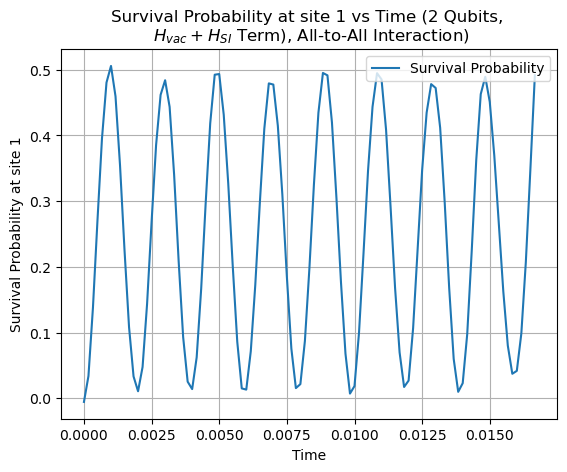

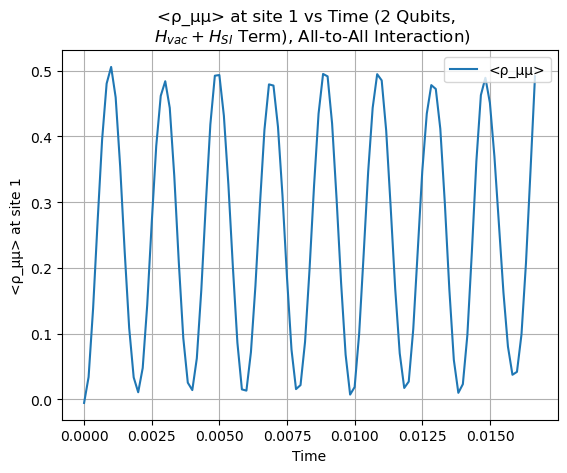

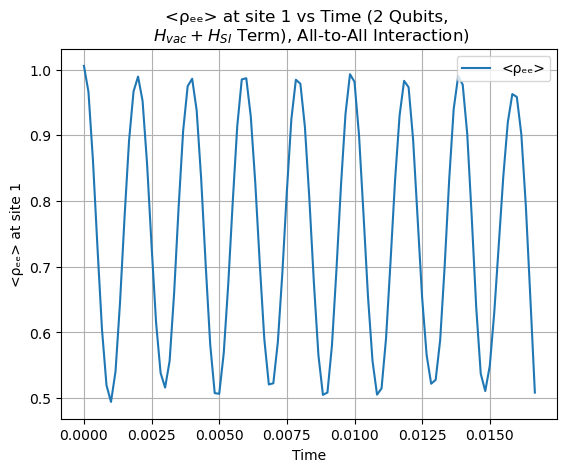

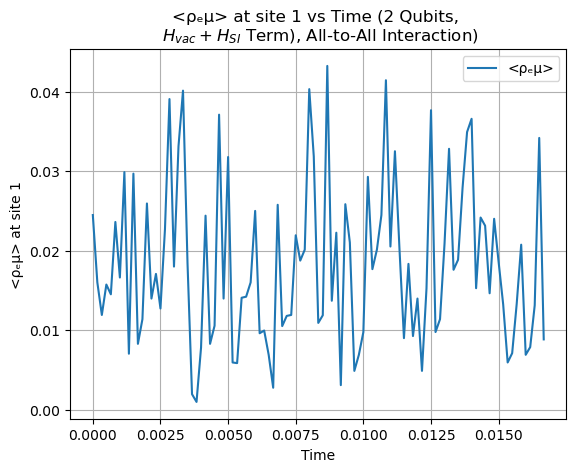

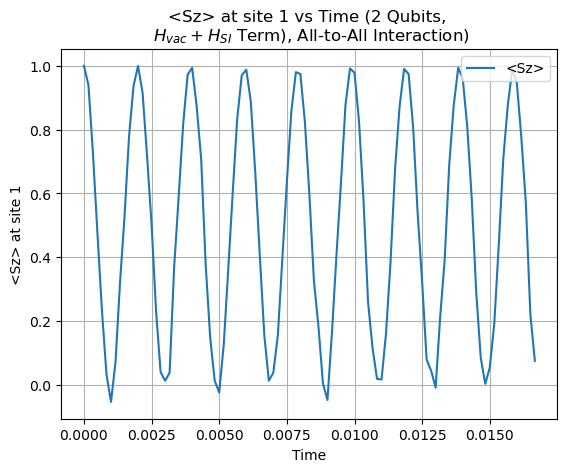

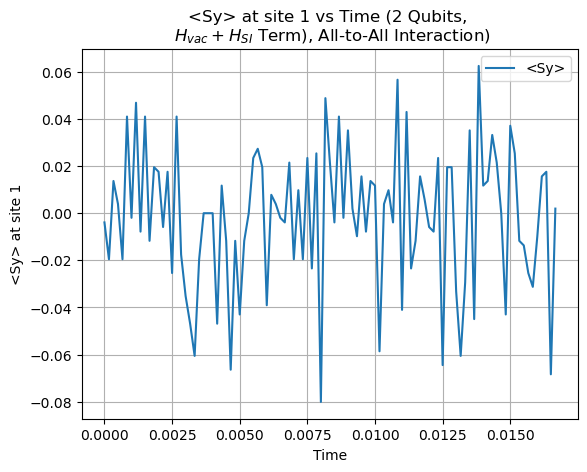

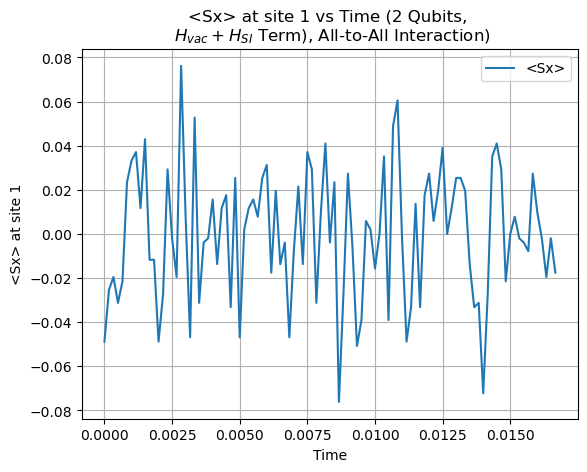

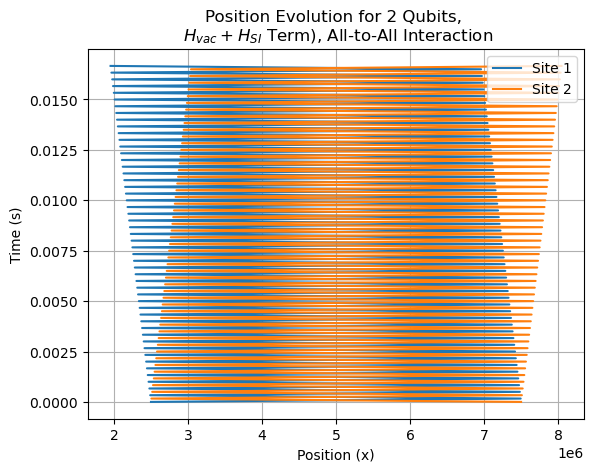

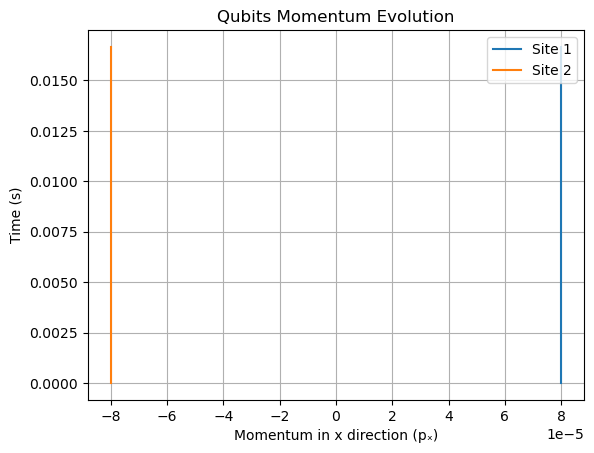

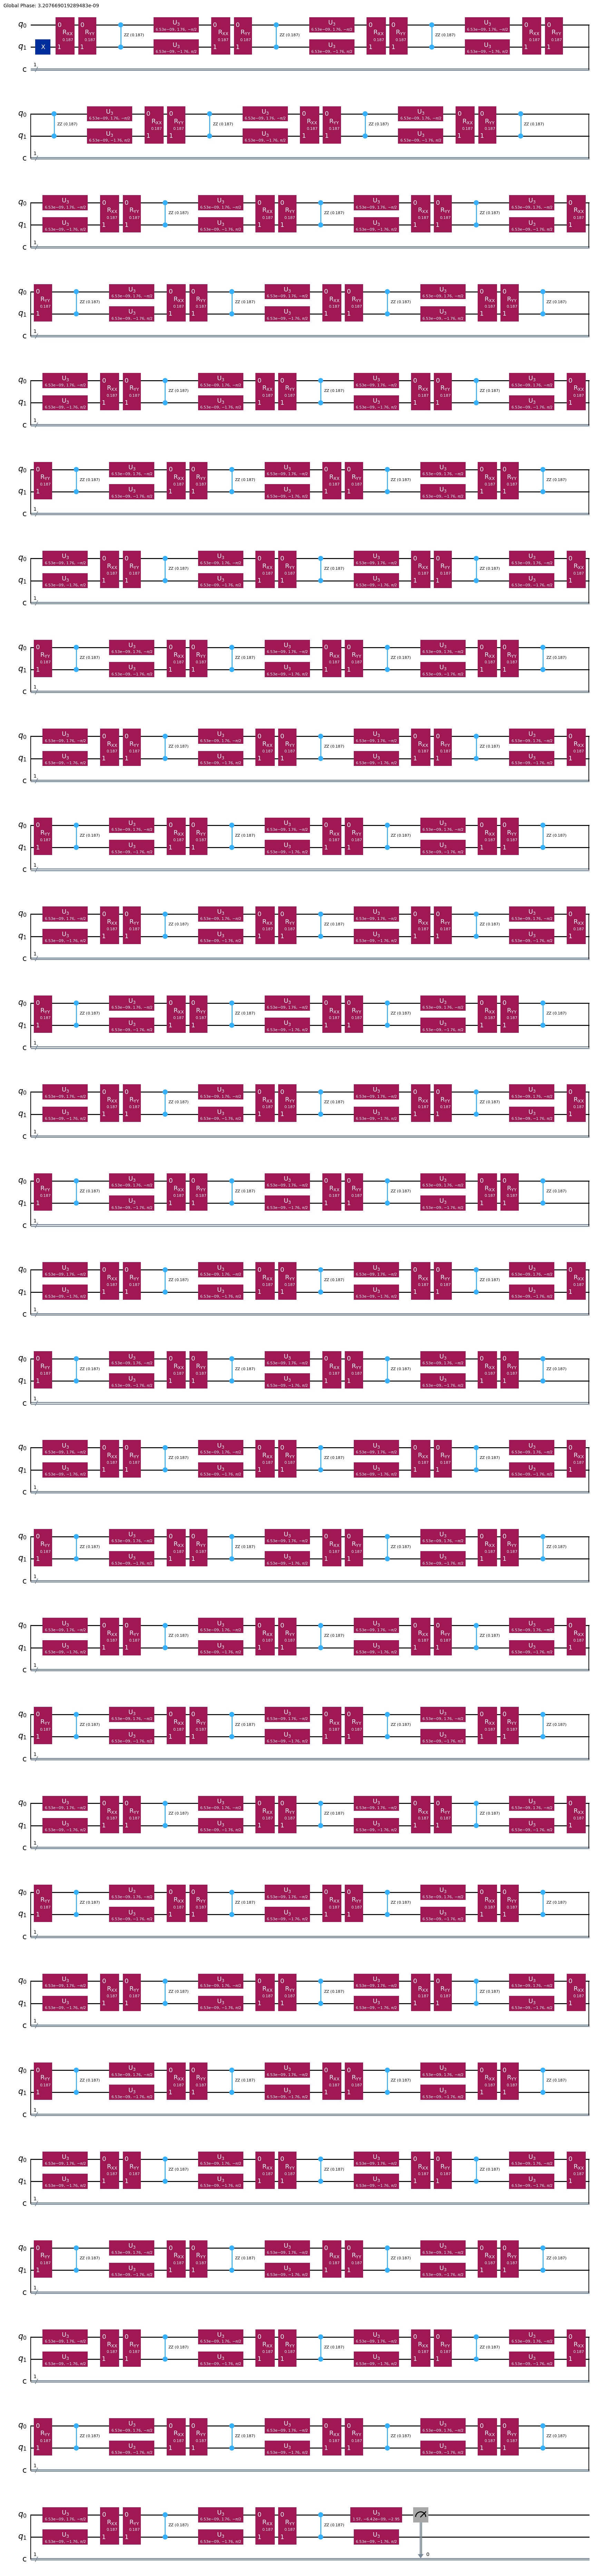

In [32]:
    
N_sites, theta_nu, omega, B, N, x, p, energy_sign, Δx, Δp, L, delta_m_squared, shape_name , shots, trotter_steps, backend, alpha,df, τ, times, ttotal,periodic= initialize_parameters()
pauli_terms = construct_hamiltonian(N, omega, B, N_sites, Δx, delta_m_squared, p, x, Δp, theta_nu, shape_name, L, τ, energy_sign)
sigma_x_values, sigma_y_values, sigma_z_values, survival_probabilities, x_values, pₓ_values, ρₑₑ_array, ρ_μμ_array, ρₑμ_array, circuit, sigma_xbar_i= evolve_and_simulate(times, omega, N_sites,x, p, L, pauli_terms, theta_nu, backend, shots, τ, alpha, df,ttotal, periodic, trotter_steps, trotter_order)
chi_square_value = chi_square_test(N_sites, ttotal, shots)
plot_results(times, shots, sigma_x_values, sigma_y_values, sigma_z_values, survival_probabilities,x_values, pₓ_values, ρₑₑ_array, ρ_μμ_array, ρₑμ_array, N_sites, ttotal)
circuit.draw(output="mpl")